### Combining samples with missing values for pay_1 with samples with none missing values

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['font.size'] = 4

In [4]:
df_main = pd.read_excel('C:/Users/J.C/Desktop/PROJECTS-CHINONSO\Data-Science-Projects/default_of_credit_card_clients__courseware_version_1_21_19 (1).xls')

### Remove samples where all features and response are zero

In [6]:
df_zero_mask = df_main == 0
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)
sum(feature_zero_mask)

315

### Use iloc for integers and loc for strings

In [8]:
df_clean = df_main.loc[~feature_zero_mask, :].copy()
print(df_clean.shape)

(29685, 25)


In [10]:
print(df_clean['ID'].nunique())

29685


### Adjust undocumented feature values

In [11]:
df_clean['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean['MARRIAGE'].value_counts()

2    15810
1    13503
3      372
Name: MARRIAGE, dtype: int64

### Fill missing data with np.nan

In [13]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'
sum(missing_pay_1_mask)

3021

In [14]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask, :].copy()
df_missing_pay_1.shape

(3021, 25)

In [16]:
df_missing_pay_1['PAY_1'].head(4)

17    Not available
28    Not available
29    Not available
54    Not available
Name: PAY_1, dtype: object

### Load dataset with missing values removed

In [20]:
df = pd.read_csv('C:/Users/J.C/Desktop/PROJECTS-CHINONSO\Data-Science-Projects/Clean_csv_2')

In [29]:
features_response = df.columns.to_list()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school', 'none', 'others', 'university']

features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### Replicate the train/test_split from earlier

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[features_response[:-1]].values, df['default payment next month'].values,
    test_size = 0.2, random_state =24
    )

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(21331, 17)
(5333, 17)
(21331,)


In [35]:
df_missing_pay_1.shape

(3021, 25)

### make similar dataframe with not available set as np.nan

In [41]:
import numpy as np

In [61]:
df_fill_pay_1 = df_missing_pay_1.copy()
df_fill_pay_1['PAY_1'] = np.nan

#split into training and testing

X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1[features_response[:-1]], df_fill_pay_1['default payment next month'], test_size=0.2, random_state=24)
    
    
#concatenate imputed data(nan values) with non missing values

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

df_fill_pay_1['PAY_1'].value_counts()

Series([], Name: PAY_1, dtype: int64)

### Create the file

In [43]:
import pickle

In [62]:
with open('C:/Users/J.C/Desktop/PROJECTS-CHINONSO\Data-Science-Projects/Activity_6.pkl', 'wb') as f:
    pickle.dump([features_response, X_train_all, y_train_all, X_test_all, y_test_all], f)

### 

### Import necessary dependencies

In [46]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [63]:
with open('C:/Users/J.C/Desktop/PROJECTS-CHINONSO\Data-Science-Projects/Activity_6.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all, y_test_all = pickle.load(f)

### Define a validation set to train XGBoost with early stopping

In [64]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=24)

In [65]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective= 'binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide' #splits at node with highest loss change
)

In [66]:
max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


In [67]:
eval_set = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

In [68]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #set parameter and fit model
    xgb_model.set_params(**{'max_leaves':max_leaves})
    xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set,
                 eval_metric='auc', verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model.predict_proba(X_val_2)[:, -1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Wall time: 2min


In [69]:
max_leaves_df_2 = pd.DataFrame({'Max leaves':max_leaves_values, 'Validation AUC': val_aucs})

In [70]:
max_leaves_df_2

,Max leaves,Validation AUC
0,5,0.774669
1,10,0.776364
2,15,0.777602
3,20,0.775791
4,25,0.774410
5,30,0.776210
6,35,0.776748
7,40,0.778592
8,45,0.776444
9,50,0.777007


<AxesSubplot:xlabel='Max leaves'>

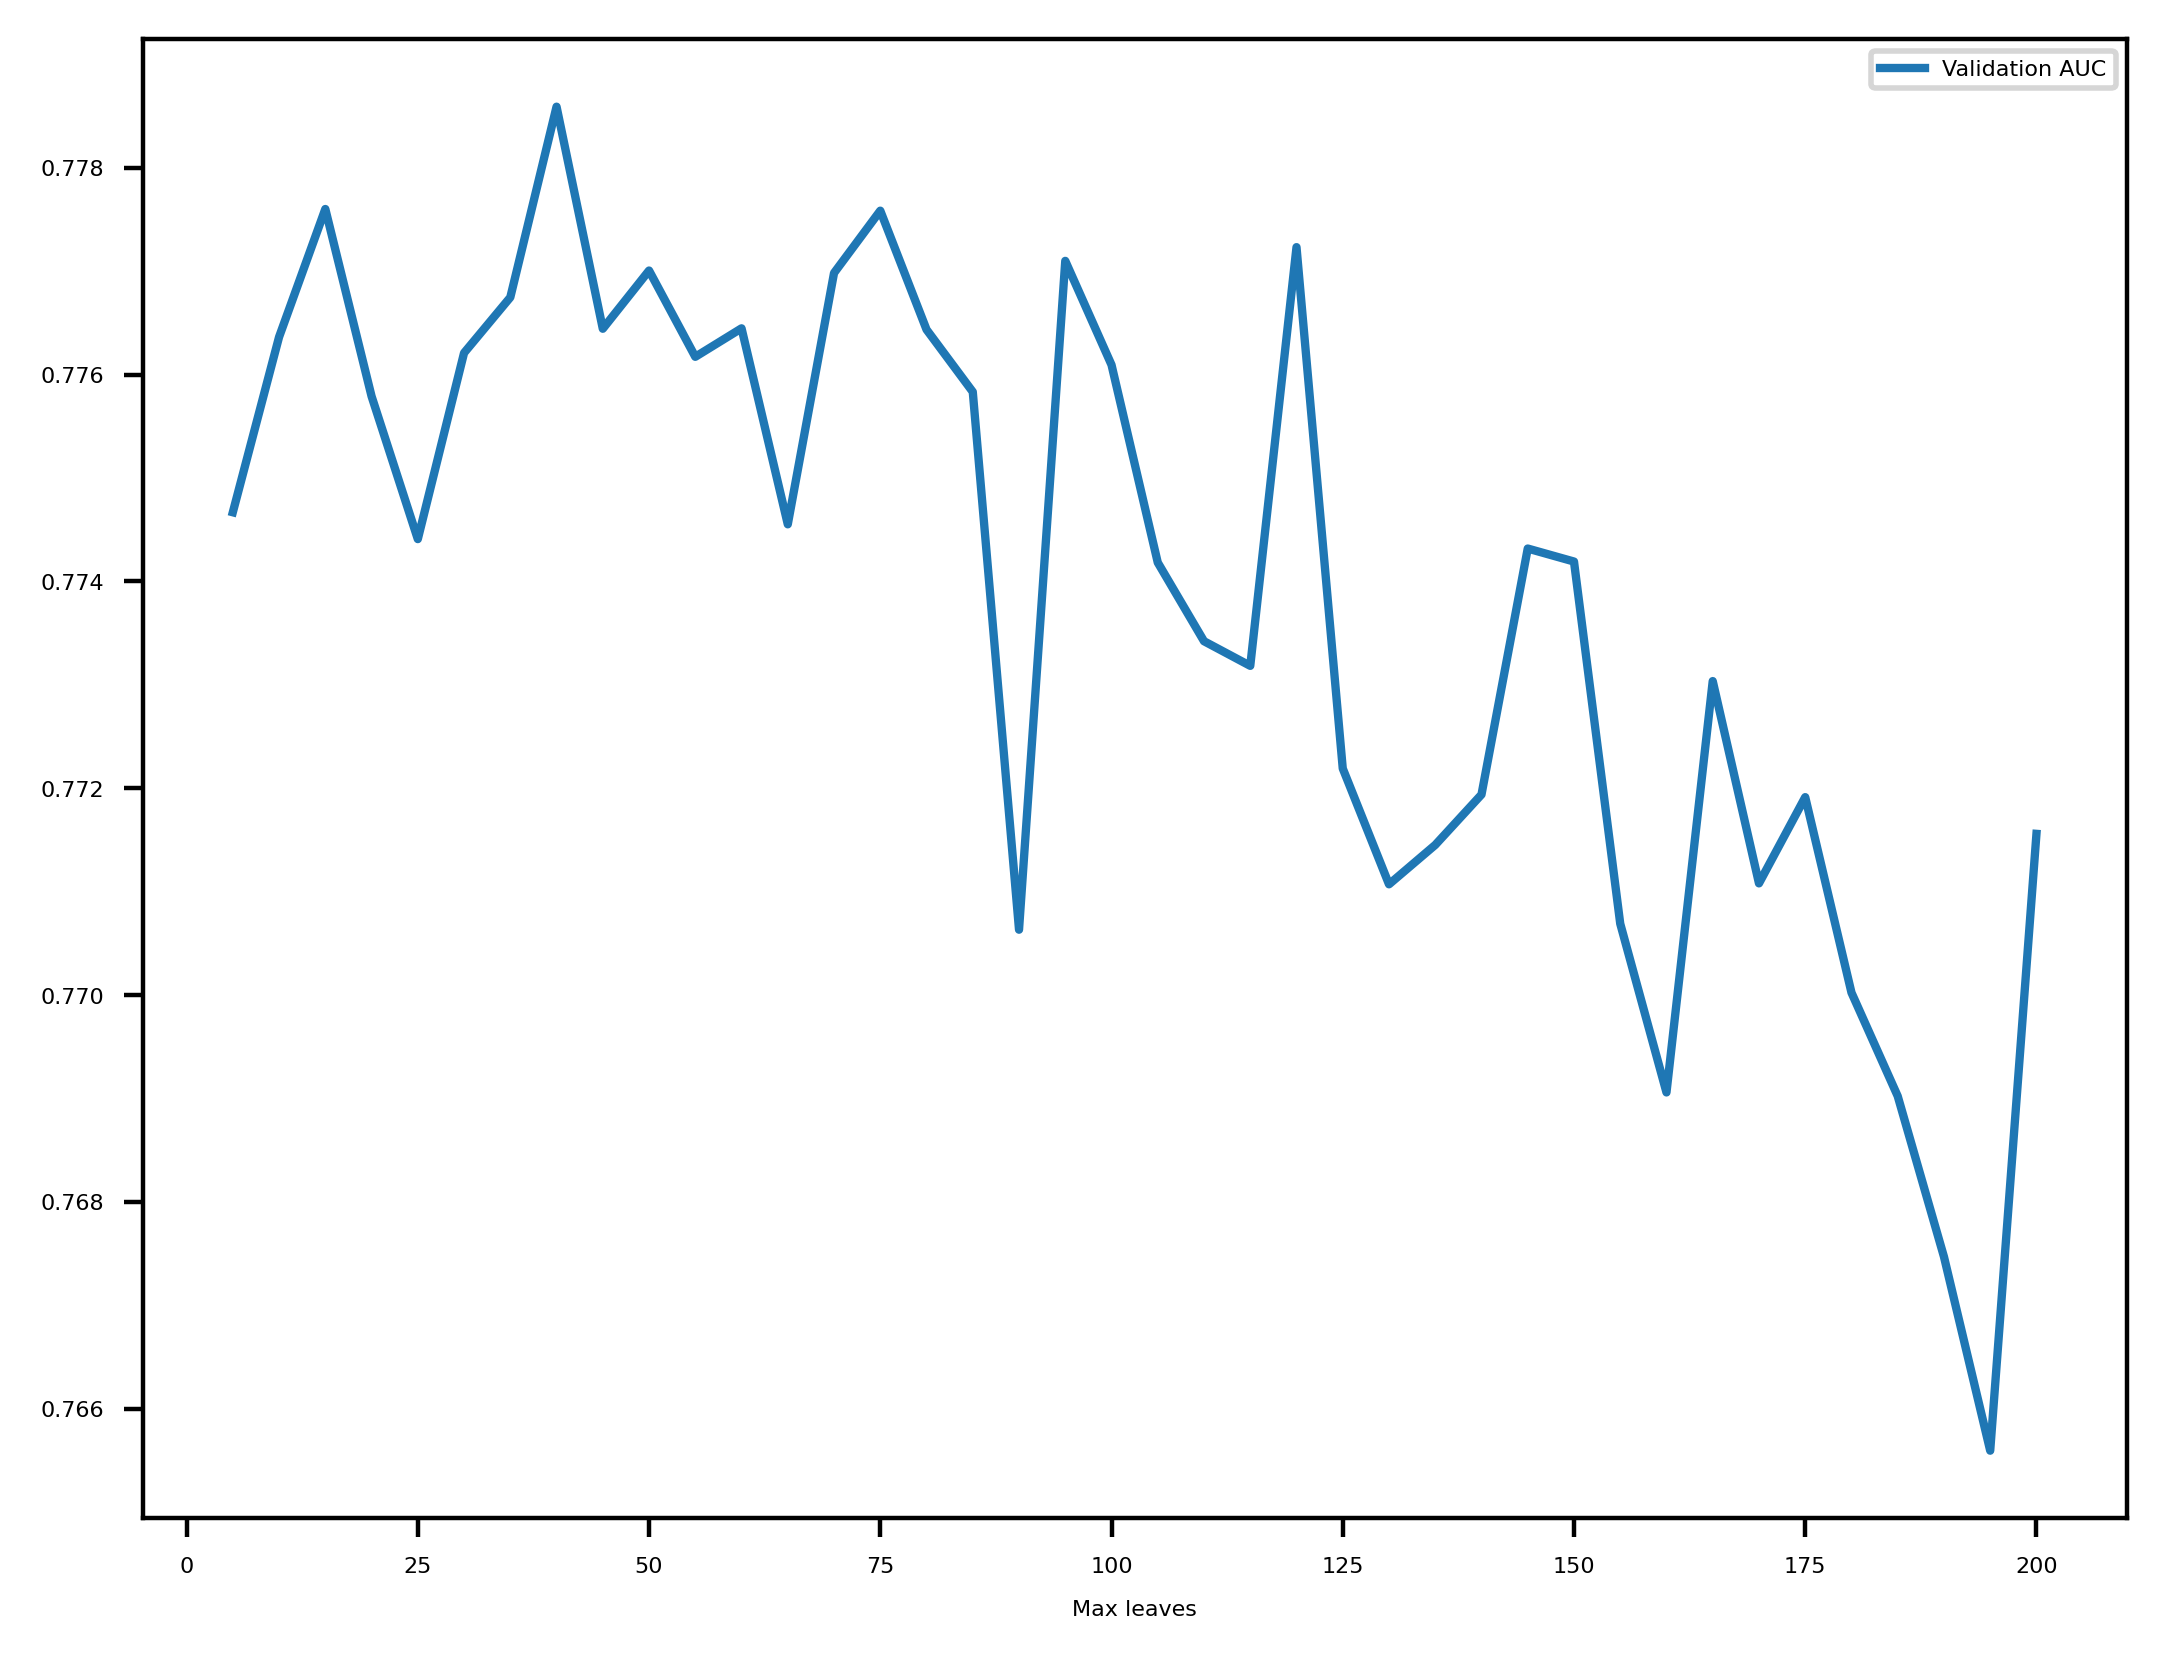

In [71]:
max_leaves_df_2.set_index('Max leaves').plot()

In [73]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2

0.7785918508068121

In [74]:
max_index_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_index_2]

,Max leaves,Validation AUC
7,40,0.778592


### Retrain with optimal hyperparameter

In [77]:
xgb_model.set_params(**{'max_leaves':40})
xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set, eval_metric='auc', verbose=False, early_stopping_rounds=30)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=0, max_leaves=40, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [79]:
#
X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])

In [80]:
X_val_2_df.head(20)

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.0,2.0,1.0,39.0,-1.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0
1,400000.0,1.0,2.0,29.0,0.0,7191.0,8856.0,6181.0,7859.0,4899.0,1466.0,2000.0,1500.0,2000.0,1000.0,500.0,1000.0
2,200000.0,2.0,2.0,26.0,0.0,22737.0,12169.0,14328.0,16222.0,9915.0,11226.0,3000.0,6000.0,3000.0,2003.0,3101.0,530.0
3,280000.0,1.0,2.0,38.0,-1.0,17878.0,14011.0,30079.0,13139.0,13989.0,15559.0,2000.0,30000.0,14000.0,1000.0,16000.0,0.0
4,80000.0,3.0,1.0,65.0,0.0,80260.0,82116.0,80299.0,81416.0,81617.0,81607.0,3750.0,3520.0,3069.0,3271.0,3262.0,3237.0
5,230000.0,1.0,2.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,20000.0,2.0,2.0,22.0,1.0,19512.0,17692.0,19136.0,20080.0,17366.0,17128.0,0.0,1736.0,1618.0,902.0,1000.0,869.0
7,170000.0,1.0,1.0,36.0,-1.0,2015.0,2015.0,2015.0,2015.0,2015.0,1925.0,2015.0,2015.0,2015.0,2015.0,1925.0,2105.0
8,400000.0,4.0,1.0,30.0,NaN,3443.0,69.0,188.0,188.0,177.0,2378.0,69.0,188.0,188.0,177.0,2400.0,11320.0
9,180000.0,1.0,2.0,31.0,0.0,17426.0,29047.0,30572.0,38043.0,39441.0,42652.0,12000.0,2000.0,8043.0,2000.0,4000.0,12500.0


### 

### SHAP Summary

In [81]:
%time explainer = shap.explainers.Tree(xgb_model, data=X_val_2_df)

Wall time: 399 ms


In [82]:
%time shap_values_2 = explainer(X_val_2_df)

 98%|===================| 4639/4750 [00:22<00:00]        

Wall time: 21.9 s


In [84]:
shap_values_2.values.shape

(4750, 17)

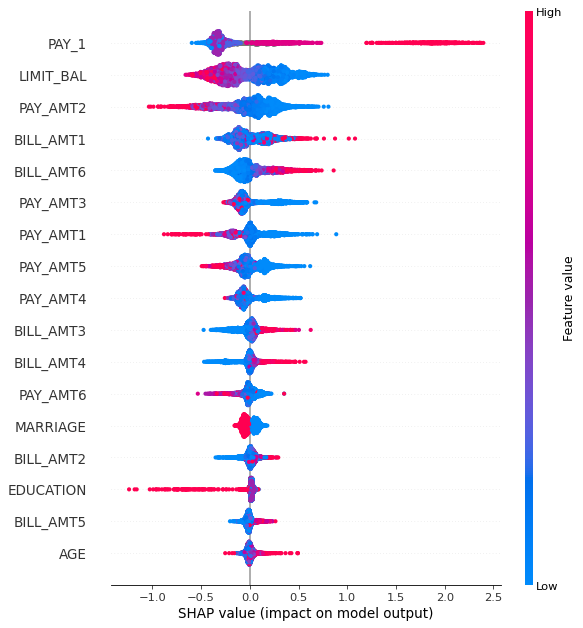

Wall time: 2.04 s


In [85]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values_2.values, X_val_2_df)

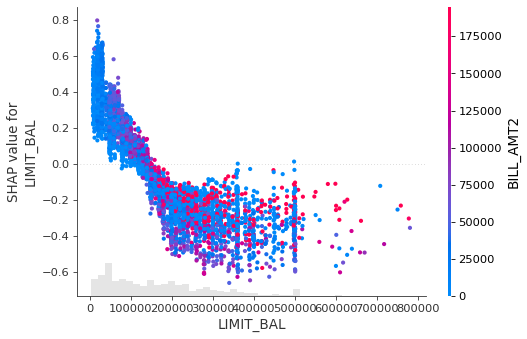

In [86]:
shap.plots.scatter(shap_values_2[:, 'LIMIT_BAL'], color=shap_values_2)

### In the figure above no feature was specified to color the Limit BAl rather the shap explainer chooses the feature with the most interaction with is bill_amt2

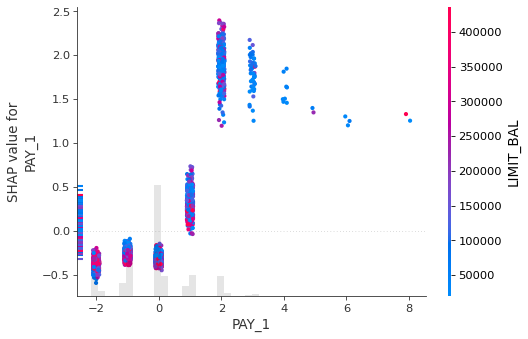

In [88]:
shap.plots.scatter(shap_values_2[:, 'PAY_1'], color=shap_values_2)

### save trained model with training and test data 

In [89]:
with open('C:/Users/J.C/Desktop/PROJECTS-CHINONSO\Data-Science-Projects/xgb_shap_model.pkl', 'wb') as f:
    pickle.dump([X_train_all, y_train_all, X_test_all, y_test_all, xgb_model], f)